### This nb creates a subset of the Happywhale training images and gets them all set up for use with `ImageDataGenerator`

If we decide to use the full set, it will be easy enough to adapt this code to structure all images for the data generator

In [1]:
import os
import random
import pandas as pd
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras

redo = False

2022-03-05 05:34:45.530715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.5/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-03-05 05:34:45.530745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/drive/')

#### Creating file structure

In [3]:
if IN_COLAB == True:
  wd = '/content/drive/Shareddrives/Whales-ML/'
  df = pd.read_csv(wd + 'train.csv')
else:
  df = pd.read_csv('data/train.csv')

# correcting mispelled species
df['species'] = df['species'].replace('kiler_whale', 'killer_whale')
df['species'] = df['species'].replace('bottlenose_dolpin', 'bottlenose_dolphin')
image_names = df['image']
sp_names = pd.unique(df['species'])
sp_names

array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'killer_whale', 'pilot_whale', 'dusky_dolphin',
       'long_finned_pilot_whale', 'sei_whale', 'spinner_dolphin',
       'cuviers_beaked_whale', 'spotted_dolphin', 'globis',
       'brydes_whale', 'commersons_dolphin', 'white_sided_dolphin',
       'short_finned_pilot_whale', 'rough_toothed_dolphin',
       'pantropic_spotted_dolphin', 'pygmy_killer_whale',
       'frasiers_dolphin'], dtype=object)

In [46]:
if IN_COLAB == True:
  train_subset_dir = '/content/drive/Shareddrives/Whales-ML/subset/train_subset/'
  validation_subset_dir = '/content/drive/Shareddrives/Whales-ML/subset/validation_subset/'
else:
    train_subset_dir = 'data/subsubset/train_subset/'
    validation_subset_dir = 'data/subsubset/validation_subset/'
    test_subset_dir = 'data/subsubset/test_subset/'

In [5]:
if redo == True:

    os.mkdir(train_subset_dir)
    os.mkdir(validation_subset_dir)

    for i in range(0, len(sp_names)):
        os.mkdir(train_subset_dir + sp_names[i])
        os.mkdir(validation_subset_dir + sp_names[i])

#### Copying files into new directory structure

In [6]:
if redo == True:

    train_dir = 'data/train_images/'
    train_nsamples = len(os.listdir(train_dir))

    # randomly selecting 4000 training images and 1000 validation images
    seed_value = 71993
    random.seed(seed_value)
    sample_indices = random.sample(range(0, train_nsamples), 5000)
    train_indices = sample_indices[0:4000]
    validation_indices = sample_indices[4000:5000]

    train_subset_df = df.filter(items = train_indices, axis=0)
    validation_subset_df = df.filter(items = validation_indices, axis=0)
    
    for sp in sp_names:
        sp_df = train_subset_df[train_subset_df['species']==sp]

        for i in range(0, len(sp_df)):
            src = train_dir + sp_df['image'].iloc[i]
            dst = train_subset_dir + sp + '/' + sp_df['image'].iloc[i]
            shutil.copyfile(src, dst)

        sp_df = validation_subset_df[validation_subset_df['species']==sp]

        for i in range(0, len(sp_df)):
            src = train_dir + sp_df['image'].iloc[i]
            dst = validation_subset_dir + sp + '/' + sp_df['image'].iloc[i]
            shutil.copyfile(src, dst)


#### Looking at the representation of each species in the subset

In [13]:
n_train = 0
n_val = 0

for sp in os.listdir(train_subset_dir):
    sp_dir = train_subset_dir + sp
    nsamples = len(os.listdir(sp_dir))
    n_train += nsamples
    print(f'{sp}: {nsamples}')
    
print('----')
    
for sp in os.listdir(validation_subset_dir):
    sp_dir = validation_subset_dir + sp
    nsamples = len(os.listdir(sp_dir))
    n_val += nsamples
    print(f'{sp}: {nsamples}')

fin_whale: 20
long_finned_pilot_whale: 4
humpback_whale: 124
blue_whale: 55
spinner_dolphin: 34
minke_whale: 21
killer_whale: 40
beluga: 131
melon_headed_whale: 17
sei_whale: 12
pilot_whale: 4
common_dolphin: 7
spotted_dolphin: 11
southern_right_whale: 16
cuviers_beaked_whale: 4
false_killer_whale: 49
gray_whale: 12
bottlenose_dolphin: 179
dusky_dolphin: 47
pantropic_spotted_dolphin: 4
short_finned_pilot_whale: 4
----
fin_whale: 3
long_finned_pilot_whale: 0
humpback_whale: 29
blue_whale: 15
spinner_dolphin: 9
minke_whale: 7
killer_whale: 11
beluga: 34
melon_headed_whale: 3
sei_whale: 2
pilot_whale: 5
common_dolphin: 1
spotted_dolphin: 2
southern_right_whale: 10
cuviers_beaked_whale: 1
false_killer_whale: 9
gray_whale: 3
bottlenose_dolphin: 39
dusky_dolphin: 11
pantropic_spotted_dolphin: 2
short_finned_pilot_whale: 2


## Data generator

In [9]:
def make_path(dataset, file_name):
  path = locals()[dataset + '_subset_dir'] + '/' + file_name
  return path

In [67]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 30
train_steps = int(n_train / batch_size)
validation_steps = int(n_val / batch_size)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (100, 100)

train_generator = train_datagen.flow_from_directory(
        train_subset_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_subset_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_subset_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 795 images belonging to 21 classes.
Found 198 images belonging to 21 classes.
Found 96 images belonging to 21 classes.


In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (30, 150, 150, 3)
labels batch shape: (30, 21)


## Building network

In [50]:
from keras import models
from keras import layers

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(21, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
#               metrics=['acc'])

In [68]:
model = models.Sequential()

model.add(layers.Conv2D(32, (6, 6), strides = (1, 1), input_shape = (100, 100, 3)))
# model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides = (1,1)))
model.add(layers.Activation('relu'))
model.add(layers.AveragePooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3), strides = (1,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dropout(0.85))

model.add(layers.Dense(21, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])

## Training and evaluating

In [69]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_steps)

Epoch 1/10
26/26 [==============================] - 49s 2s/step - loss: 3.0339 - acc: 0.1791 - val_loss: 2.4024 - val_acc: 0.3556
Epoch 2/10
26/26 [==============================] - 47s 2s/step - loss: 2.4125 - acc: 0.2771 - val_loss: 2.2846 - val_acc: 0.3500
Epoch 3/10
26/26 [==============================] - 46s 2s/step - loss: 2.1061 - acc: 0.3660 - val_loss: 2.7094 - val_acc: 0.3000
Epoch 4/10
26/26 [==============================] - 47s 2s/step - loss: 1.9376 - acc: 0.4366 - val_loss: 2.0818 - val_acc: 0.3889
Epoch 5/10
26/26 [==============================] - 46s 2s/step - loss: 1.7374 - acc: 0.4575 - val_loss: 2.0090 - val_acc: 0.4611
Epoch 6/10
26/26 [==============================] - 47s 2s/step - loss: 1.6200 - acc: 0.4993 - val_loss: 2.1917 - val_acc: 0.3944
Epoch 7/10
26/26 [==============================] - 47s 2s/step - loss: 1.4296 - acc: 0.5569 - val_loss: 2.2176 - val_acc: 0.4389
Epoch 8/10
26/26 [==============================] - 47s 2s/step - loss: 1.2590 - acc: 0.59

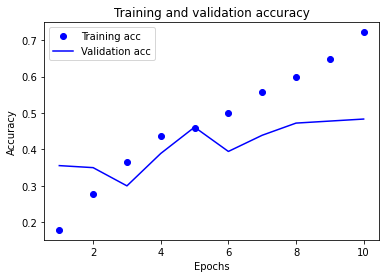

In [70]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

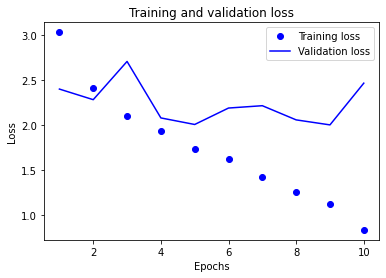

In [71]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [72]:
test_results = model.evaluate(test_generator)
test_acc = test_results[1]
print(f"Test accuracy: {test_acc}")

4/4 [==============================] - 5s 1s/step - loss: 2.1283 - acc: 0.4688
Test accuracy: 0.46875
